<a href="https://colab.research.google.com/github/rexian/ML/blob/main/agenticai/langgraph/Multi_agents_llm_mcp_protocol.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### The notebook contains a multi-agents LLM pipeline
### The pipeline contains 2 agents:
* Research Agent: The agent uses MCP protocol to search web using an external tool - Duckduckgo
* Summarizer Agent: The agent summarizes the search result and generate the final summary

In [42]:
!pip install -q -U langgraph langchain_google_genai duckduckgo-mcp mcp-use fastmcp

# MCP server configuration for Duckduckgo search

In [ ]:
!pip install --upgrade duckduckgo-mcp

In [46]:
!duckduckgo-mcp serve

2025-06-05 06:03:21,476 - root - INFO - Starting DuckDuckGo MCP Server v1.2 (STDIO transport)
2025-06-05 06:03:21,476 - root - INFO - Press Ctrl+C to stop the server
[06/05/25 06:03:21] INFO     Starting MCP server 'duckduckgo_mcp'  ]8;id=651843;file:///usr/local/lib/python3.11/dist-packages/fastmcp/server/server.py\server.py]8;;\:]8;id=122218;file:///usr/local/lib/python3.11/dist-packages/fastmcp/server/server.py#797\797]8;;\
                             with transport 'stdio'                             
2025-06-05 06:03:21,496 - FastMCP.fastmcp.server.server - INFO - Starting MCP server 'duckduckgo_mcp' with transport 'stdio'
2025-06-05 06:03:34,601 - root - INFO - Server stopped by user
Exception ignored in: <module 'threading' from '/usr/lib/python3.11/threading.py'>
Traceback (most recent call last):
  File "/usr/lib/python3.11/threading.py", line 1590, in _shutdown
^C


In [47]:
!duckduckgo-mcp search "What is A2A protocol" --max-results 5

2025-06-05 06:03:45,133 - primp - INFO - response: https://html.duckduckgo.com/html 200
[
  {
    "title": "A2A Protocol - Agent-to-Agent Communication",
    "url": "https://a2aprotocol.ai/",
    "snippet": "A2A Protocol is an open standard that enables AI agents to communicate and collaborate across different platforms and frameworks, regardless of their underlying technologies. It's designed to maximize the benefits of agentic AI by enabling true multi-agent scenarios."
  },
  {
    "title": "What is The Agent2Agent Protocol (A2A) and Why You Must Learn It Now",
    "url": "https://huggingface.co/blog/lynn-mikami/agent2agent",
    "snippet": "The A2A protocol addresses these challenges by defining a standard set of rules and message formats for inter-agent communication. It acts as an abstraction layer, hiding the underlying implementation details of individual agents. Key Principles of A2A: Openness: A2A is an open protocol, fostering collaboration and preventing vendor lock-in ..."

In [64]:
import os
import getpass
import functools
import operator
from typing import TypedDict, Annotated, List

from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import HumanMessage, ToolMessage
from langchain_core.tools import Tool
from langgraph.graph import StateGraph, END

In [65]:
if not os.environ.get("GOOGLE_API_KEY"):
  os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter API key for GOOGLE AI Endpoints: ")

In [69]:
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash", temperature=0)

# MCP Client application for Duckduckgo search

In [70]:
from fastmcp import FastMCP
from duckduckgo_mcp import duckduckgo_search
mcp = FastMCP(name="DuckDuckGoServer")

@mcp.tool()
def search(query: str, max_results: int = 5) -> list:
    """Search DuckDuckGo for the given query."""
    return duckduckgo_search(query, max_results)
result = search('Compare A2A with mcp protocol', 3)
print(result)

[{'title': 'A2A vs MCP: Compare AI Agent Communication Protocols', 'url': 'https://a2a-mcp.org/', 'snippet': 'A2A vs MCP: AI Protocol Evolution Shaping the Future of AI Agent Collaboration. AI is moving towards an ecosystem of tools and agents that reason, delegate, and collaborate. In an era where protocols become the new battleground, A2A and MCP emerge, attempting to establish standards for two key aspects of agent interaction.'}, {'title': 'MCP vs A2A: Comprehensive Comparison of AI Agent Protocols', 'url': 'https://medium.com/@neo-cruz/mcp-vs-a2a-comprehensive-comparison-of-ai-agent-protocols-862a969bac47', 'snippet': "Origin and Development. Google introduced A2A with an emphasis on creating a standard for interoperable, multi-agent systems. The timing of A2A's release shortly after OpenAI's adoption of MCP ..."}, {'title': 'A2A vs MCP: The Protocol Revolution in AI Architecture | A2A Protocol ...', 'url': 'https://a2aprotocol.ai/docs/guide/a2a-vs-mcp.html', 'snippet': 'The A2A v

In [81]:
@mcp.tool()
def google_search(query: str, max_results: int = 3) -> str:
    """
    A web search and returns a predefined response based on the query.
    """
    print(f"Search for: '{query}'...")
    result = []
    for res in duckduckgo_search(query, max_results):
      result.append(res['snippet'])
    return ''.join(result)

[06/05/25 06:21:22] WARNING  Tool already exists: google_search                                  ]8;id=212822;file:///usr/local/lib/python3.11/dist-packages/fastmcp/tools/tool_manager.py\tool_manager.py]8;;\:]8;id=151878;file:///usr/local/lib/python3.11/dist-packages/fastmcp/tools/tool_manager.py#89\89]8;;\

In [83]:
search_tool = Tool(
    name="search",
    func=google_search,
    description="Google searching information on the internet about AI, LangGraph, or multi-agent systems."
)
llm_with_tools = llm.bind_tools([search_tool])

In [84]:
class AgentState(TypedDict):
    query: str
    research_results: Annotated[List[str], operator.add]
    summary: str
    messages: Annotated[List[HumanMessage | ToolMessage], operator.add]

In [85]:
def researcher_node(state: AgentState) -> AgentState:
    """
    The Researcher agent node.
    """
    print(" RESEARCHER AGENT ")
    current_query = state["query"]
    messages = state["messages"]

    if not state["research_results"]:
        llm_response = llm_with_tools.invoke(
            messages + [HumanMessage(content=f"Based on the main query '{current_query}', what specific information should I search for to gather relevant details?")]
        )

        tool_calls = llm_response.tool_calls

        if tool_calls and tool_calls[0].name == "search":
            search_term = tool_calls[0].args.get("query", current_query)
            print(f"Researcher found a search tool call: {search_term}")
            tool_output = search_tool.invoke({"query": search_term})
            messages.append(ToolMessage(tool_output, tool_call_id=tool_calls[0].id))
            state["research_results"].append(tool_output)
            print(f"Research results added: {tool_output[:50]}...")
        else:
            tool_output = search_tool.invoke({"query": current_query})
            messages.append(ToolMessage(tool_output, tool_call_id="fallback_search_id"))
            state["research_results"].append(tool_output)
            print(f"Research results added (fallback): {tool_output[:50]}...")

    else:
        print("Research already performed. Moving to next stage.")
    return {"research_results": state["research_results"], "messages": messages}

In [86]:
def summarizer_node(state: AgentState) -> AgentState:
    """
    The Summarizer agent node.
    """
    print(" SUMMARIZER AGENT ")
    all_research_results = "\n\n".join(state["research_results"])
    messages = state["messages"]

    if not all_research_results:
        summary = "No research results available to summarize."
        print(summary)
    else:
        summary_prompt = (
            f"Please provide a concise summary of the following information. "
            f"Focus on key concepts related to multi-agent pipelines and LangGraph:\n\n"
            f"{all_research_results}"
        )

        summary_response = llm.invoke(messages + [HumanMessage(content=summary_prompt)])
        summary = summary_response.content
        print(f"Generated summary: {summary[:100]}...") # Print a snippet

    state["summary"] = summary
    messages.append(HumanMessage(content=f"Final Summary: {summary}"))
    return {"summary": summary, "messages": messages}

In [87]:
def should_continue(state: AgentState) -> str:
    """
    Determines whether the pipeline should continue with research or proceed to summarization.
    """
    print(" DECIDING NEXT STEP ")
    if state["research_results"]:
        print("Research results found. Proceeding to summarize.")
        return "summarize"
    else:
        return "research"

In [88]:
# Initialize the StateGraph with the defined AgentState
workflow = StateGraph(AgentState)

# Add the nodes to the workflow
workflow.add_node("researcher", researcher_node)
workflow.add_node("summarizer", summarizer_node)

# Set the entry point for the graph
workflow.set_entry_point("researcher")

workflow.add_conditional_edges(
    "researcher",
    should_continue,
    {
        "research": "researcher",
        "summarize": "summarizer",
    },
)

workflow.add_edge("summarizer", END)
app = workflow.compile()

# Run the Pipeline

# Define the initial input for the pipeline
initial_inputs = {
    "query": "Compare A2A with mcp protocol",
    "research_results": [],
    "summary": "",
    "messages": [HumanMessage(content="Initial request: Compare A2A with mcp protocol")]
}

print(" STARTING MULTI-AGENT PIPELINE ")
final_state = app.invoke(initial_inputs)

print(" PIPELINE EXECUTION COMPLETE ")
print(" FINAL STATE ")
print(f"Original Query: {final_state['query']}")
print(f"Accumulated Research Results: {final_state['research_results']}")
print(f"Final Summary: {final_state['summary']}")
print(" MESSAGE HISTORY ")
for msg in final_state['messages']:
    if isinstance(msg, HumanMessage):
        print(f"Human: {msg.content}")
    elif isinstance(msg, ToolMessage):
        print(f"Tool Output (from {msg.tool_call_id}): {msg.content}")
    else:
        print(f"Other Message: {msg}")

 STARTING MULTI-AGENT PIPELINE 
 RESEARCHER AGENT 
Search for: 'Compare A2A with mcp protocol'...
Research results added (fallback): A2A vs MCP: AI Protocol Evolution Shaping the Futu...
 DECIDING NEXT STEP 
Research results found. Proceeding to summarize.
 SUMMARIZER AGENT 
Generated summary: A2A and MCP are emerging protocols aiming to standardize AI agent interaction. **MCP (Model Context ...
 PIPELINE EXECUTION COMPLETE 
 FINAL STATE 
Original Query: Compare A2A with mcp protocol
Accumulated Research Results: ["A2A vs MCP: AI Protocol Evolution Shaping the Future of AI Agent Collaboration. AI is moving towards an ecosystem of tools and agents that reason, delegate, and collaborate. In an era where protocols become the new battleground, A2A and MCP emerge, attempting to establish standards for two key aspects of agent interaction.Origin and Development. Google introduced A2A with an emphasis on creating a standard for interoperable, multi-agent systems. The timing of A2A's release s

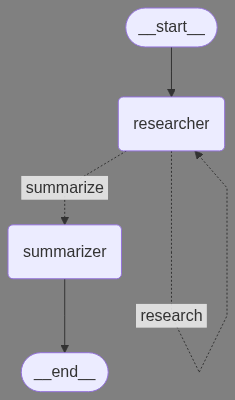

In [89]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles
import nest_asyncio

nest_asyncio.apply()

try:
    display(Image(app.get_graph().draw_mermaid_png(
            curve_style=CurveStyle.LINEAR,
            node_colors=NodeStyles(first="#ffdfba", last="#baffc9", default="#fad7de"),
            wrap_label_n_words=9,
            output_file_path=None,
            draw_method=MermaidDrawMethod.API,
            background_color="grey",
            padding=10,
        )))
except Exception:
    pass